In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

from IRSMicroLensing import IRSCaustics as IRSC
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
pixels = 1000
ang_width = 5
ang_res = ang_width / pixels

x_rays = np.linspace(-ang_width/2 - ang_res/2 + ang_res/(2*1), ang_width/2 + ang_res/2 - ang_res/(2*1), 1*pixels)
y_rays = np.linspace(-ang_width/2 - ang_res/2 + ang_res/(2*1), ang_width/2 + ang_res/2 - ang_res/(2*1), 1*pixels)

x, y = np.meshgrid(x_rays, y_rays)

In [6]:
d = 0.5
num_rs = 10
num_thetas = 10

rs = np.linspace(1-(d/2), 1+(d/2), num_rs).reshape(-1, 1)
thetas = np.linspace(0, 2*np.pi - (2*np.pi/num_thetas), num_thetas).reshape(1, -1)

x = np.dot(rs, np.cos(thetas))
y = np.dot(rs, np.sin(thetas))

print(np.prod(np.shape(x)))

print(x)

100
[[ 0.75        0.60676275  0.23176275 -0.23176275 -0.60676275 -0.75
  -0.60676275 -0.23176275  0.23176275  0.60676275]
 [ 0.80555556  0.65170813  0.24893036 -0.24893036 -0.65170813 -0.80555556
  -0.65170813 -0.24893036  0.24893036  0.65170813]
 [ 0.86111111  0.69665352  0.26609797 -0.26609797 -0.69665352 -0.86111111
  -0.69665352 -0.26609797  0.26609797  0.69665352]
 [ 0.91666667  0.74159891  0.28326558 -0.28326558 -0.74159891 -0.91666667
  -0.74159891 -0.28326558  0.28326558  0.74159891]
 [ 0.97222222  0.7865443   0.30043319 -0.30043319 -0.7865443  -0.97222222
  -0.7865443  -0.30043319  0.30043319  0.7865443 ]
 [ 1.02777778  0.83148969  0.3176008  -0.3176008  -0.83148969 -1.02777778
  -0.83148969 -0.3176008   0.3176008   0.83148969]
 [ 1.08333333  0.87643508  0.33476841 -0.33476841 -0.87643508 -1.08333333
  -0.87643508 -0.33476841  0.33476841  0.87643508]
 [ 1.13888889  0.92138047  0.35193602 -0.35193602 -0.92138047 -1.13888889
  -0.92138047 -0.35193602  0.35193602  0.92138047]
 [

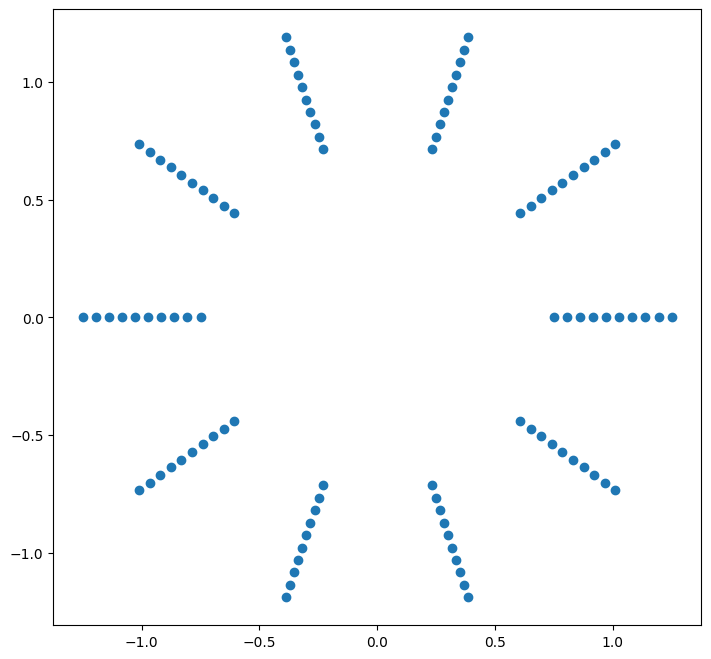

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.scatter(x, y)
ax.set_aspect('equal')

plt.show()

In [128]:
lens_att = [
    [0, 0, 0.01, 1],
    [0.2, 0, 0.01, 0.001]
]

lens_att = np.array(lens_att)

L = np.shape(lens_att)[0]

# Total mass of lens objects
total_M = np.sum(lens_att[:, 3])

In [129]:
z = x + y*1j # [theta_e] NxN
zbar = np.conj(z) # [theta_e] NxN

# Translating into complex coordinates (lens coordinates)
zm = lens_att[:, 0] + lens_att[:, 1]*1j # [theta_e] 1xL
epsilon = lens_att[:, 3] / total_M # [dimensionless] 1xL

zmbar = np.conj(zm) # [theta_e] 1xL

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sums = np.zeros(shape=np.shape(zbar), dtype=np.complex128)
    sum = IRSMLS.IRSMain.lens_eq(L, sums, zbar, zmbar, epsilon)

zeta = z - sum # [theta_e]

# Extracting positions from complex number
xs = np.real(zeta) # [theta_e]
ys = np.imag(zeta) # [theta_e]

In [130]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.scatter(x, y)
ax.scatter(xs, ys)
ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

plt.show()

In [118]:
pixels = 3000
ang_width = 0.1
ang_res = ang_width / pixels

x_pixels = np.linspace(-ang_width/2, ang_width/2, pixels)
y_pixels = np.linspace(-ang_width/2, ang_width/2, pixels)
X_p, Y_p = np.meshgrid(x_pixels, y_pixels)

In [119]:
bool_x = (xs < -ang_width/2) | (xs > ang_width/2)
indx = np.where(bool_x, np.nan, xs)

bool_y = (ys < -ang_width/2) | (ys > ang_width/2)
indy = np.where(bool_y, np.nan, ys)

indx = indx/ang_res + pixels/2
indy = indy/ang_res + pixels/2

bool_arr_x = np.isnan(indx)
bool_arr_y = np.isnan(indy)

# Replacing nan values with some out of bounds value and making the numbers into integers
indx_nonan = np.where(bool_arr_x, pixels*2, indx)
indy_nonan = np.where(bool_arr_y, pixels*2, indy)

indx = np.where(bool_arr_x, int(pixels*2), indx_nonan.astype(int))
indy = np.where(bool_arr_y, int(pixels*2), indy_nonan.astype(int))

# Combining indx and indy into matrix of 2-element arrays (x and y coordinates)
comb_mat = np.stack((indx, indy), axis=2)

# repetitions, counts = np.unique(ar=comb_mat.reshape(-1, 2), axis=0, return_counts=True)
stacked_mat = comb_mat.reshape(-1, 2)
repetitions, counts = IRSMLS.IRSCaustics.calc_uniques(stacked_mat)

In [120]:
def calc_mags1(pixels, magnifications, repetitions, counts):
    '''
    Calculates magnifications using Numba's jit method with C-like compiling for faster computing.

    Parameters
    ----------
    pixels : int32
    magnifications : 2D int64 Numpy array
    repetitions : 2D int64 Numpy array
    counts : 1D int64 Numpy array

    Returns
    -------
    magnifications : 2D int64 Numpy array
    '''
    for i, N_pix in enumerate(counts):
        if pixels*2 not in repetitions[i]:
            magnifications[repetitions[i, 0], repetitions[i, 1]] += N_pix

    return magnifications

# @nb.jit(nb.int64[:, :](nb.int32, nb.float64[:, :], nb.int64[:, :], nb.int64[:]), nopython=True, fastmath=True)
def calc_mags2(pixels, magnifications, repetitions, counts):
    '''
    Calculates magnifications using Numba's jit method with C-like compiling for faster computing.

    Parameters
    ----------
    pixels : int32
    magnifications : 2D int64 Numpy array
    repetitions : 2D int64 Numpy array
    counts : 1D int64 Numpy array

    Returns
    -------
    magnifications : 2D int64 Numpy array
    '''
    A_im = 2*np.pi*d
    N_im = np.prod(np.shape(x))
    sigma_im = N_im/A_im

    print(sigma_im)

    A_pix = ang_res**2
    print(A_pix)

    for i, N_pix in enumerate(counts):
        if pixels*2 not in repetitions[i]: 
            magnifications[repetitions[i, 0], repetitions[i, 1]] += (N_pix/A_pix)/sigma_im
            # magnifications[repetitions[i, 0], repetitions[i, 1]] += N_pix

    return magnifications

In [121]:
magnifications_1 = np.zeros(shape=(pixels, pixels), dtype=np.int64)
magnifications_1 = calc_mags1(pixels, magnifications_1, repetitions, counts)

print(magnifications_1)

magnifications_2 = np.zeros(shape=(pixels, pixels), dtype=np.float64)
magnifications_2 = calc_mags2(pixels, magnifications_2, repetitions, counts)

print(magnifications_2)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3183098.8618379068
1.1111111111111113e-09
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [122]:
magnifications_log_1 = np.where(magnifications_1 == 0, 0.1, magnifications_1)
magnifications_log_1 = np.log10(magnifications_log_1)
magnifications_log_1 = np.where(magnifications_log_1 == -1, 0, magnifications_log_1)

magnifications_log_2 = np.where(magnifications_2 == 0, 0.1, magnifications_2)
magnifications_log_2 = np.log10(magnifications_log_2)
magnifications_log_2 = np.where(magnifications_log_2 == -1, 0, magnifications_log_2)

In [123]:
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot()

ax1.imshow(magnifications_1, vmin=0, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2])

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot()

ax2.imshow(magnifications_log_2, vmin=0, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2])

plt.show()

In [ ]:
pixels = 1000
ang_width = 5
rays_per_pixel = 4

lens_att = [
    [-0.5, 0, 0.01, 1],
    [0.5, 0, 0.01, 1]
]

caus = IRSMLS.IRSCaustics(pixels=pixels, ang_width=ang_width, lens_att=lens_att, rays_per_pixel=rays_per_pixel, annulus=d)
caus.plot(save_plot=False, show_lenses=True)

plt.show()

Creating mesh grid: 0.687 seconds
Calculating source pixels: 2.337 seconds
Calculating indices of translated pixel after deflection: 0.51 seconds
Calculating translated pixels: 1.592 seconds
Finding pixel repetitions and counts: 0.257 seconds
Incrementing pixel magnifications based on counts and repetitions: 0.107 seconds
Plotting magnification map: 0.184 seconds
---------------------
Total time: 5.8 seconds
